In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# for webscraping import Beautiful Soup 
from bs4 import BeautifulSoup

import xml

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')


Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [3]:
#The Wikipedia page was changed on November, 2019
#We will use the older version
url = "https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canad%D7%A9a:_M&oldid=926306543"
res = requests.get(url)

In [4]:
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))
data = pd.read_json(df[0].to_json(orient='records'))
df = data[data['Borough'] != 'Not assigned']
df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


In [5]:
#Grouping by Borough and Postcode
df = df.groupby(['Postcode','Borough'], as_index=False).agg(','.join)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Postcode,Borough,Neighbourhood
0,M6L,North York,"Downsview,North Park,Upwood Park"
1,M2K,North York,Bayview Village
2,M5P,Central Toronto,"Forest Hill North,Forest Hill West"
3,M8Y,Etobicoke,"Humber Bay,King's Mill Park,Kingsway Park Sout..."
4,M4L,East Toronto,"The Beaches West,India Bazaar"


In [6]:
df.shape

(103, 3)

In [186]:
###Second part of the assignment

In [7]:
geospatial_url = "https://cocl.us/Geospatial_data"
latlondata = pd.read_csv(geospatial_url)

In [8]:
latlondata.columns=['Postcode','Latitude','Longitude']
latlondata.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [14]:
#Merging of the neighbourhood database and the geospatial data
data = pd.merge(df, latlondata, on='Postcode')
data.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M6L,North York,"Downsview,North Park,Upwood Park",43.713756,-79.490074
1,M2K,North York,Bayview Village,43.786947,-79.385975
2,M5P,Central Toronto,"Forest Hill North,Forest Hill West",43.696948,-79.411307
3,M8Y,Etobicoke,"Humber Bay,King's Mill Park,Kingsway Park Sout...",43.636258,-79.498509
4,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572


In [15]:
# 3d part of the assignment
data['Location'] = list(zip(data['Latitude'], data['Longitude']))

In [16]:
#How to find a geographical location in geolocator

In [17]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [18]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

In [19]:
# add markers to map
for lat, lng, label in zip(data['Latitude'], data['Longitude'], data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

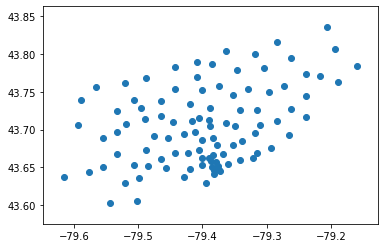

In [27]:
#Kmeans
datal=data[['Longitude','Latitude']]
import matplotlib.pyplot as plt
plt.scatter(datal['Longitude'], datal['Latitude'])

In [28]:
k_means = KMeans(init="k-means++", n_clusters=4, n_init=12)

In [29]:
k_means.fit(datal)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=12, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [30]:
labels = pd.DataFrame.from_dict(k_means.labels_, dtype='float')
labels.columns=['Labels']
labels.head()

,Labels
0,2.0
1,3.0
2,0.0
3,2.0
4,0.0


In [31]:
datal=datal.join(labels)
datal.head()

,Longitude,Latitude,Labels
0,-79.490074,43.713756,2.0
1,-79.385975,43.786947,3.0
2,-79.411307,43.696948,0.0
3,-79.498509,43.636258,2.0
4,-79.315572,43.668999,0.0


In [34]:
locations = datal[['Latitude', 'Longitude']]
locationlist = locations.values.tolist()

In [35]:
def regioncolors(counter):
    if counter['Labels'] == 1:
        return 'green'
    elif counter['Labels'] == 0:
        return 'blue'
    elif counter['Labels'] == 2:
        return 'red'
    else:
        return 'darkblue'

In [37]:
datal["color"] = datal.apply(regioncolors, axis=1)
datal.head()

,Longitude,Latitude,Labels,color
0,-79.490074,43.713756,2.0,red
1,-79.385975,43.786947,3.0,darkblue
2,-79.411307,43.696948,0.0,blue
3,-79.498509,43.636258,2.0,red
4,-79.315572,43.668999,0.0,blue


In [38]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)


for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point],
                  icon=folium.Icon(color=datal["color"][point],
                                   icon_color='white',
                                   icon='circle',
                                   angle=0, prefix='fa')).add_to(map_toronto)

display(map_toronto)